In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'Chest X-Ray Images (Pneumonia).zip',
 'chest_xray',
 'cnn_medical.h5',
 'Medical Image Analysis with CNN.ipynb',
 'N1 (1).jpeg',
 'N1 (2).jpeg',
 'N1 (3).jpeg',
 'P1 (1).jpeg',
 'P1 (2).jpeg',
 'P1 (3).jpeg']

In [3]:
# Data Exploration

In [4]:
data_dir = 'chest_xray'

In [5]:
def explore_data(directory):
    for folder in ['train','test','val']:
        folder_path = os.path.join(directory, folder).replace('\\', '/')
        num_images = 0
        for label in ['NORMAL','PNEUMONIA']:
            label_folder = os.path.join(folder_path,label).replace('\\', '/')
            images = os.listdir(label_folder)
            num_images += len(images)
            print(f"{folder.upper()} - {label}: {len(images)} images")
        print(f"{folder.upper()}: Total {num_images} images\n")
explore_data(data_dir)

TRAIN - NORMAL: 1341 images
TRAIN - PNEUMONIA: 3875 images
TRAIN: Total 5216 images

TEST - NORMAL: 234 images
TEST - PNEUMONIA: 390 images
TEST: Total 624 images

VAL - NORMAL: 8 images
VAL - PNEUMONIA: 8 images
VAL: Total 16 images



In [6]:
# Data Processing

In [7]:
train_dir = os.path.join(data_dir, 'train').replace('\\','/')
val_dir = os.path.join(data_dir, 'val').replace('\\','/')
test_dir = os.path.join(data_dir, 'test').replace('\\','/')

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Rescaling values from 0 to 1 to make it easier on the model
    rotation_range=20, # making the model more robust to different orientations of the object in images.
    width_shift_range=0.2, # It simulates the effect of the object being in different horizontal positions within the image, which helps the model generalize better to object location.
    height_shift_range=0.2, # It simulates the effect of the object being in different vertical positions within the image, which helps the model generalize better to object location.
    shear_range=0.2, # This can make the model more robust to variations in the object's appearance from different angles.
    zoom_range=0.2, # This randomly zooms inside the pictures by up to 20%, simulating the effect of the object being at different distances from the camera.
    horizontal_flip=True, # This can significantly increase the model's ability to generalize by doubling the orientation variations.
    fill_mode='nearest' # 'nearest' means it will fill with the nearest pixel values. This choice affects how the model perceives the shape and content of transformed images at their borders.
)

In [9]:
test_val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(225,225),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(225,225),
    batch_size=32,
    class_mode='binary'
)
val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(225,225),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
# Model Building

In [25]:
model = models.Sequential([
    # CNN Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(225, 225, 3)), 
    layers.MaxPooling2D((2, 2)), 

    # CNN Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),  

    # CNN Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),  
    layers.MaxPooling2D((2, 2)),  

    # CNN Layer 4
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),  

    # Flatten the output of the CNN layers before passing it to the Dense layer
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  
    layers.Dense(1, activation='sigmoid')
]) # This model generate accuracy 83.5%, Let's see the second below

In [12]:
model = models.Sequential([
    # CNN Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(225, 225, 3)), 
    layers.MaxPooling2D((2, 2)), 

    # CNN Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),  

    # CNN Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),  
    layers.MaxPooling2D((2, 2)),  

    # CNN Layer 4
    layers.Conv2D(256, (3, 3), activation='relu'),  # Increased filters
    layers.MaxPooling2D((2, 2)),  

    # Added CNN Layer 5
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Added CNN Layer 6
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output of the CNN layers before passing it to the Dense layer
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),  # Increased units
    layers.Dense(1, activation='sigmoid')
]) # This model gives accuracy 83.65%. Very close to the above one


In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [15]:
model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
163/163 [==============================] - 462s 3s/step - loss: 0.5624 - accuracy: 0.7421 - val_loss: 0.7229 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 721s 4s/step - loss: 0.4308 - accuracy: 0.7903 - val_loss: 1.2397 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 1049s 6s/step - loss: 0.3110 - accuracy: 0.8585 - val_loss: 0.4659 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 1101s 7s/step - loss: 0.2770 - accuracy: 0.8802 - val_loss: 0.5002 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 1277s 8s/step - loss: 0.2711 - accuracy: 0.8788 - val_loss: 0.6645 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 1110s 7s/step - loss: 0.2618 - accuracy: 0.8863 - val_loss: 0.5424 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 860s 5s/step - loss: 0.2350 - accuracy: 0.9016 - val_loss: 1.0755 - val_accuracy: 0.

In [ ]:
# Model Evaluation

In [16]:
test_generator.shuffle = False
predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5 , 1, 1).reshape(-1)
actual_classes = test_generator.classes
report = classification_report(actual_classes,predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

20/20 [==============================] - 16s 762ms/step
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



C:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


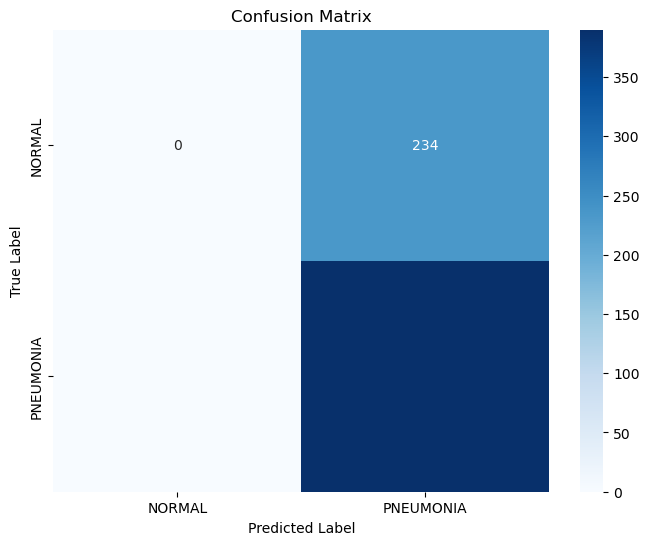

In [17]:
conf_matrix = confusion_matrix(actual_classes, predicted_classes)
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
model.save('cnn_medical.h5')
print('Saved')

Saved


In [18]:
# Test the accuracy of the model and print it
from tensorflow.keras.models import load_model

# Load the model
model = load_model('cnn_medical.h5')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=(225, 225),
    batch_size=32,
    class_mode='binary', 
    shuffle=False 
)
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy*100:.2f}%')


Found 624 images belonging to 2 classes.
20/20 [==============================] - 13s 636ms/step - loss: 0.4153 - accuracy: 0.8365
Test accuracy: 83.65%


In [22]:
# Take images list from the user and predict it's values
from tensorflow.keras.models import load_model
import cv2
import numpy as np

model = load_model('cnn_medical.h5')

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = cv2.resize(img, (225, 225)) 
    img = img / 255.0  
    img = np.expand_dims(img, axis=0) 
    return img

def predict_batch(image_paths):
    for image_path in image_paths:
        processed_image = preprocess_image(image_path)
        prediction = model.predict(processed_image)
        # the model was trained to predict 1 for "PNEUMONIA" and 0 for "Normal"
        if prediction[0][0] > 0.5:
            print(f"{image_path}: PNEUMONIA with a probability of {prediction[0][0] * 100:.2f}%")
        else:
            print(f"{image_path}: Normal with a probability of {(1 - prediction[0][0]) * 100:.2f}%")

image_paths = ['N1 (1).jpeg', 'N1 (2).jpeg', 'N1 (3).jpeg','P1 (1).jpeg','P1 (2).jpeg','P1 (3).jpeg']
predict_batch(image_paths)


1/1 [==============================] - 0s 90ms/step
N1 (1).jpeg: Normal with a probability of 55.88%
1/1 [==============================] - 0s 36ms/step
N1 (2).jpeg: PNEUMONIA with a probability of 74.96%
1/1 [==============================] - 0s 33ms/step
N1 (3).jpeg: PNEUMONIA with a probability of 55.00%
1/1 [==============================] - 0s 39ms/step
P1 (1).jpeg: PNEUMONIA with a probability of 81.66%
1/1 [==============================] - 0s 36ms/step
P1 (2).jpeg: PNEUMONIA with a probability of 95.55%
1/1 [==============================] - 0s 38ms/step
P1 (3).jpeg: PNEUMONIA with a probability of 97.48%
